In [2]:
import numpy as np
np.set_printoptions(precision=8)
from matplotlib import pyplot as plt

def zc_sequence(N, u, q):
    n = np.arange(N)
    arg = -np.pi*u*n*(n+(N%2)+2*q)/N
    return np.exp(1j*arg)

In [6]:
a = np.zeros((22, 2))
b = np.ones((22, 3))

np.hstack([a, b])

array([[0., 0., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 1., 1., 1.]])

In [234]:
nfft = 64
ncp = 16

train_sym1_f_tx = np.zeros(nfft, dtype=complex)
np.random.seed(1349)
train_sym1_f_tx[np.arange(2, 23, 2)] = np.random.choice([-1, 1], np.arange(2, 23, 2).size)
train_sym1_f_tx[np.arange(-2, -23, -2)] = np.random.choice([-1, 1], np.arange(-2, -23, -2).size)
train_sym1_t_tx = np.fft.ifft(train_sym1_f_tx)

ofdm_sym_f_tx = np.zeros(nfft, dtype=complex)
np.random.seed(123)
ofdm_sym_f_tx[5:25] = np.random.choice([1, -1], 25-5) #+ 1j*np.random.choice([1, -1], 20-10)
ofdm_sym_f_tx[-25:-5] = np.random.choice([1, -1], 25-5) #+ 1j*np.random.choice([1, -1], 20-10)
ofdm_sym_t_tx = np.fft.ifft(ofdm_sym_f_tx)


data = np.fromfile(open("data/tmp"), dtype=np.complex64)

rx_iq_t = data[:(64+16)*2 + 100]

<IPython.core.display.Javascript object>


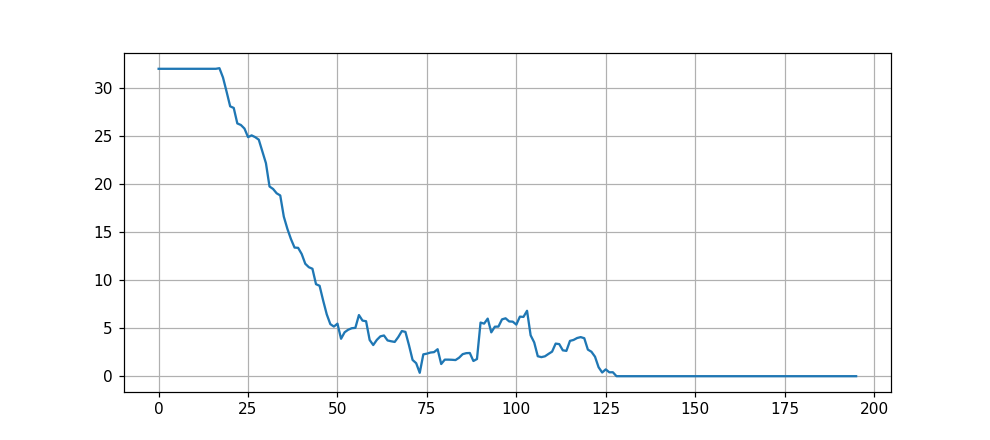

<IPython.core.display.Javascript object>


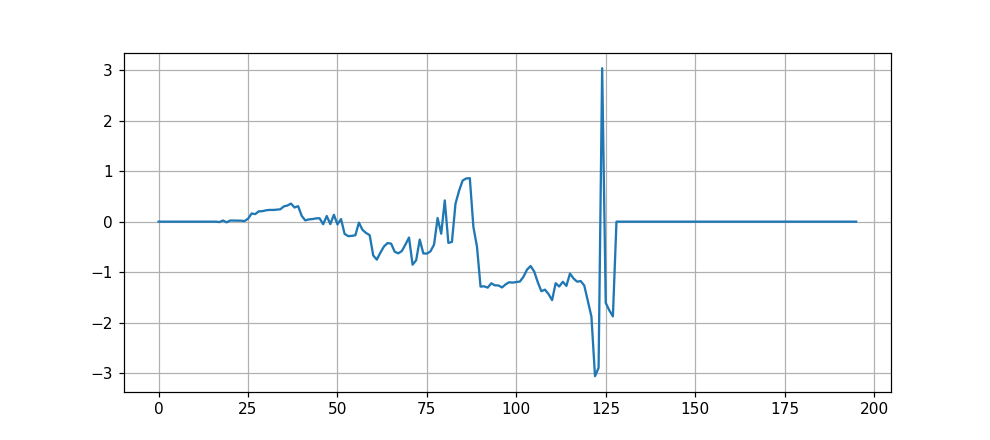

In [235]:
%matplotlib notebook

sync_corr = np.zeros(rx_iq_t.size - nfft, dtype=complex)
for i in range(sync_corr.size):
    sync_corr[i] = rx_iq_t[i:i+nfft//2].conj()@rx_iq_t[i+nfft//2:i+nfft]

plt.figure(figsize=(9, 4))
plt.plot(np.abs(sync_corr))
plt.grid(True)


plt.figure(figsize=(9, 4))
plt.plot(np.angle(sync_corr))
plt.grid(True)

In [236]:
# freq_sync
corr_avg = np.mean(sync_corr[:16])
freq_offset = np.angle(corr_avg)/(nfft/2)
print(freq_offset/(2*np.pi))

rx_iq_off1 = rx_iq_t*np.exp(-1j*freq_offset*np.arange(rx_iq_t.size))

0.0


<IPython.core.display.Javascript object>


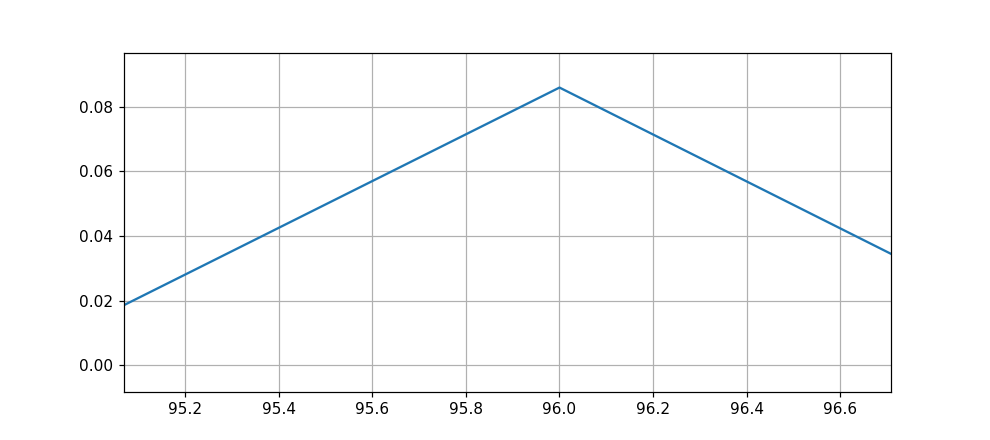

/tmp/ipykernel_7178/93298229.py:7: RuntimeWarning: invalid value encountered in cdouble_scalars
  cross_corr[i] = (rx_iq_off1[i:i+nfft].conj() @ ofdm_sym_t_tx) / \


In [237]:
%matplotlib notebook

plt.figure(figsize=(9, 4))

cross_corr = np.zeros(rx_iq_off1.size - nfft, dtype=complex)
for i in range(cross_corr.size):
    cross_corr[i] = (rx_iq_off1[i:i+nfft].conj() @ ofdm_sym_t_tx) / \
                    (rx_iq_off1[i:i+nfft].conj()@rx_iq_off1[i:i+nfft])

plt.plot(np.abs(cross_corr))
plt.grid(True)

In [238]:
def angle_roll(ang):
    ang[ang>np.pi] -= 2*np.pi
    ang[ang<-np.pi] += 2*np.pi
    return ang

<IPython.core.display.Javascript object>


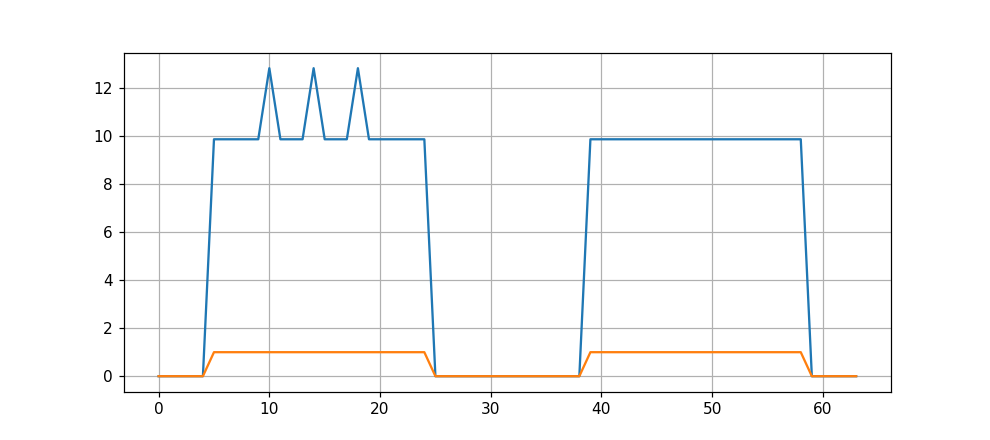

<IPython.core.display.Javascript object>


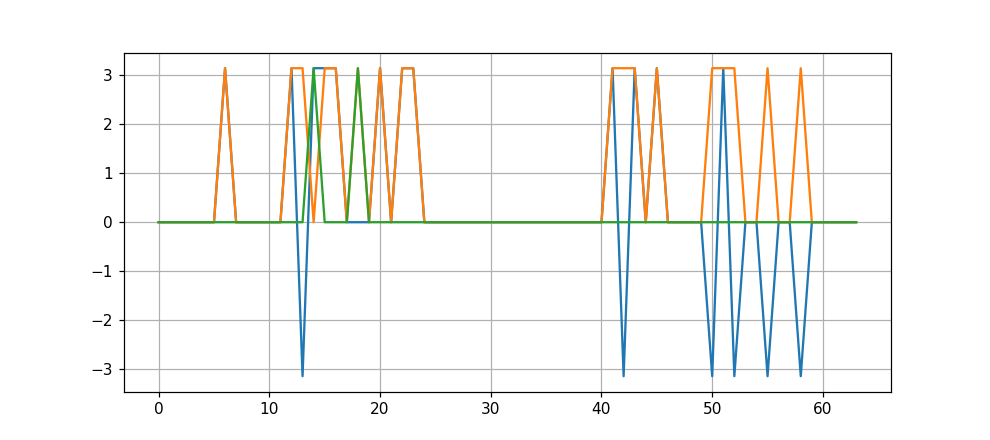

<IPython.core.display.Javascript object>


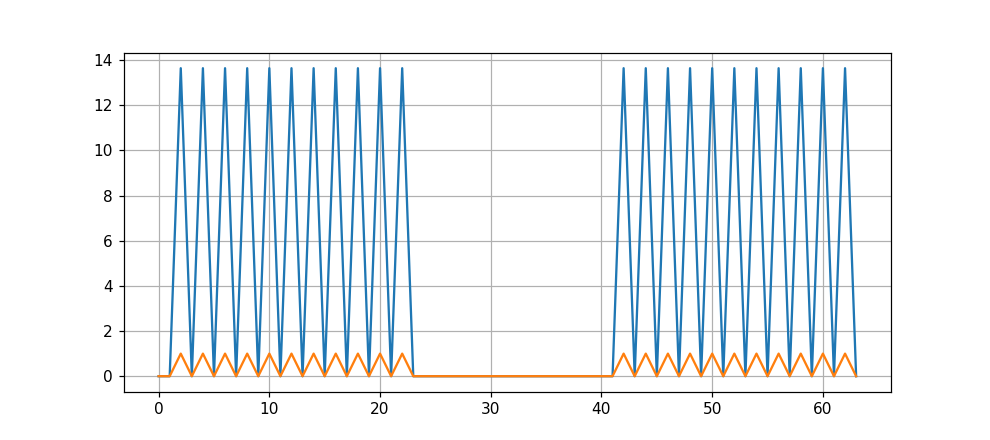

<IPython.core.display.Javascript object>


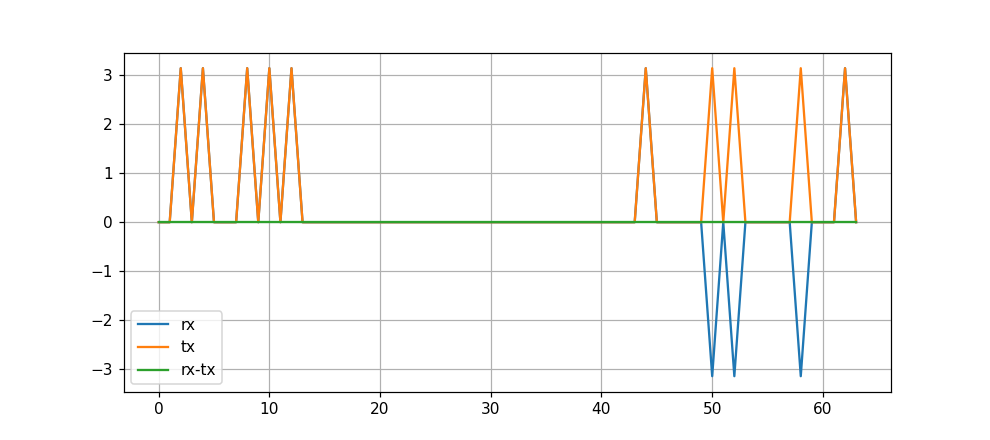

In [242]:
%matplotlib notebook

train_sym1_f_rx = np.fft.fft(rx_iq_off1[ncp//2:ncp//2 + nfft])
train_sym1_f_rx *= np.exp(2j*np.pi*np.arange(nfft)*(ncp//2)/nfft)

ofdm_sym_f_rx = np.fft.fft(rx_iq_off1[(nfft+ncp) + ncp//2: (nfft+ncp) + ncp//2 + nfft])
ofdm_sym_f_rx *= np.exp(2j*np.pi*np.arange(nfft)*(ncp//2)/nfft)

plt.figure(figsize=(9, 4))
plt.plot(np.abs(ofdm_sym_f_rx))
plt.plot(np.abs(ofdm_sym_f_tx))
plt.grid(True)

ofdm_sym_f_rx[np.abs(ofdm_sym_f_rx)<1e-2] = 0

plt.figure(figsize=(9, 4))
plt.plot(np.angle(ofdm_sym_f_rx))
plt.plot(np.angle(ofdm_sym_f_tx))
plt.plot(angle_roll(np.angle(ofdm_sym_f_rx) - np.angle(ofdm_sym_f_tx)))
plt.grid(True)

plt.figure(figsize=(9, 4))
plt.plot(np.abs(train_sym1_f_rx))
plt.plot(np.abs(train_sym1_f_tx))
plt.grid(True)

train_sym1_f_rx[np.abs(train_sym1_f_rx)<1e-2] = 0

plt.figure(figsize=(9, 4))
plt.plot(np.angle(train_sym1_f_rx), label='rx')
plt.plot(np.angle(train_sym1_f_tx), label='tx')
plt.plot(angle_roll(np.angle(train_sym1_f_rx) - np.angle(train_sym1_f_tx)), label='rx-tx')
plt.grid(True)
plt.legend()


In [90]:
ofdm_sym_f_rx

array([-4.423e-06-5.296e-06j, -4.431e-06-5.181e-06j,
       -4.503e-06-5.171e-06j, -4.637e-06-5.251e-06j,
       -4.883e-06-5.467e-06j, -5.274e-06-5.862e-06j,
       -5.928e-06-6.536e-06j, -7.117e-06-7.684e-06j,
       -9.688e-06-9.797e-06j, -1.815e-05-1.447e-05j,
        2.225e-01+2.213e-02j, -4.384e-02+2.193e-01j,
       -6.514e-02+2.139e-01j,  8.580e-02-2.065e-01j,
       -1.056e-01+1.971e-01j, -1.858e-01-1.244e-01j,
        1.420e-01-1.727e-01j,  1.583e-01-1.580e-01j,
        1.417e-01+1.730e-01j, -1.860e-01+1.240e-01j,
       -6.908e-06+1.306e-05j, -2.100e-06+7.060e-06j,
       -1.103e-06+5.151e-06j, -7.918e-07+4.293e-06j,
       -6.782e-07+3.834e-06j, -6.381e-07+3.592e-06j,
       -6.076e-07+3.453e-06j, -5.958e-07+3.392e-06j,
       -5.894e-07+3.389e-06j, -5.641e-07+3.415e-06j,
       -5.340e-07+3.487e-06j, -5.061e-07+3.584e-06j,
       -4.574e-07+3.726e-06j, -4.175e-07+3.883e-06j,
       -3.675e-07+4.086e-06j, -2.876e-07+4.322e-06j,
       -2.009e-07+4.611e-06j, -9.947e-08+4.976

In [145]:
train_sym1_t = np.zeros((train_sym1_repeat, train_sym1_len), dtype=complex)
for i in range(train_sym1_repeat):
    train_sym1_t[i] = rx_iq_t[i*train_sym1_len:(i+1)*train_sym1_len]
    
freq_offset1 = []
for i in range(train_sym1_repeat-1):
    corr = train_sym1_t[i] @ train_sym1_t[i+1].conj()
    freq_offset1.append(-np.angle(corr)/train_sym1_len)

print(np.array(freq_offset1)*nfft/2/np.pi)
print(np.std(freq_offset1)*nfft/(2*np.pi))
freq_offset1 = np.mean(freq_offset1)

rx_iq_t_off1 = rx_iq_t * np.exp(1j*-freq_offset1*np.arange(rx_iq_t.size))

[-0.643 -0.33  -0.17  -0.162 -0.123 -0.171 -0.203]
0.16869988821939993


In [146]:
train1_seq_len = train_sym1_len*train_sym1_repeat
corr2 = rx_iq_t_off1[train1_seq_len + ncp//2: train1_seq_len + ncp//2 + train_sym2_len].conj()@ \
        rx_iq_t_off1[train1_seq_len + ncp//2 + train_sym2_len: train1_seq_len + ncp//2 + 2*train_sym2_len]

freq_offset2 = np.angle(corr2)/train_sym2_len
print(freq_offset2)

rx_iq_t_off2 = rx_iq_t_off1 * np.exp(1j*-freq_offset2*np.arange(rx_iq_t_off1.size))

-0.006442226198357364


<IPython.core.display.Javascript object>


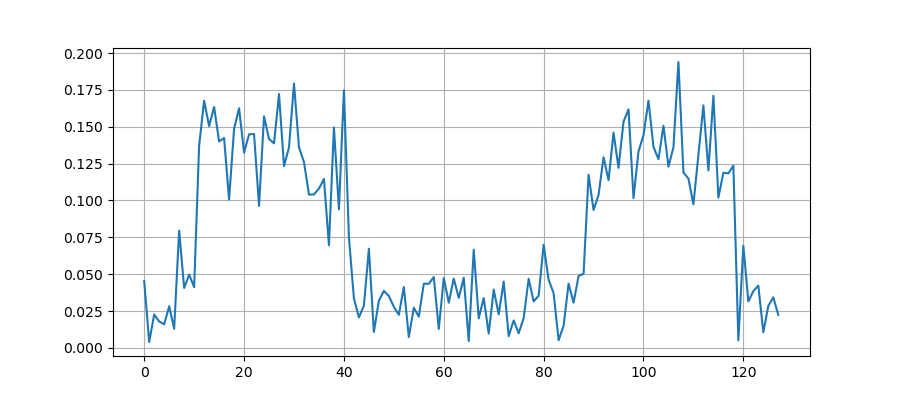

<IPython.core.display.Javascript object>


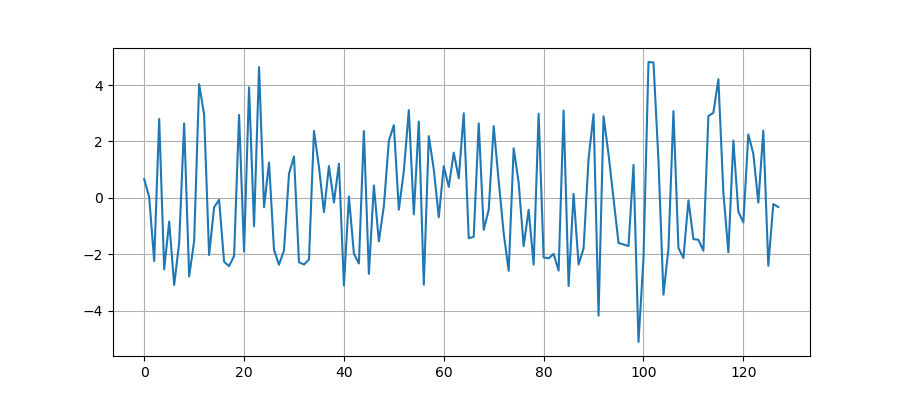

In [147]:
%matplotlib notebook

train2_seq_len = train_sym2_len*2 + ncp
train_seq_len = train1_seq_len + train2_seq_len
ofdm_sym_t = rx_iq_t_off2[train_seq_len + ncp//2: train_seq_len + ncp//2 + nfft]# * np.exp(2j*np.pi*(-1/nfft)*np.arange(nfft))
ofdm_sym_f = np.fft.ifft(ofdm_sym_t) * np.exp(2j*np.pi*np.arange(nfft)*(ncp - ncp//2)/nfft)

ofdm_sym_f_tx = np.zeros(nfft, dtype=complex)
    
np.random.seed(123)
ofdm_sym_f_tx[10:40] = (np.random.choice([1, -1], 40-10) + 1j*np.random.choice([1, -1], 40-10))/np.sqrt(2)
ofdm_sym_f_tx[-40:-10] = (np.random.choice([1, -1], 40-10) + 1j*np.random.choice([1, -1], 40-10))/np.sqrt(2)


plt.figure(figsize=(9, 4))
plt.plot(np.abs(ofdm_sym_f))
plt.grid(True)
plt.figure(figsize=(9, 4))
plt.plot(np.angle(ofdm_sym_f) - np.angle(ofdm_sym_f_tx))
plt.grid(True)

<IPython.core.display.Javascript object>


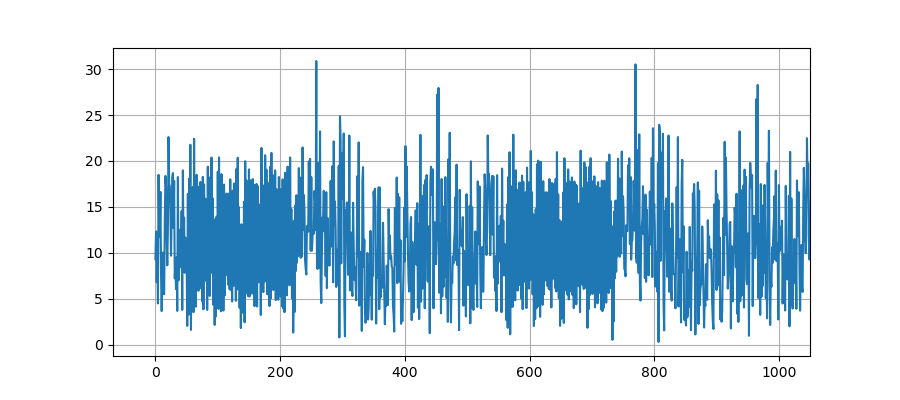

In [72]:
%matplotlib notebook

plt.figure(figsize=(9, 4))
plt.plot(np.abs(np.correlate(rx_iq_t_off2, np.roll(train_sym2.conj(), 0))))
plt.grid(True)

<IPython.core.display.Javascript object>


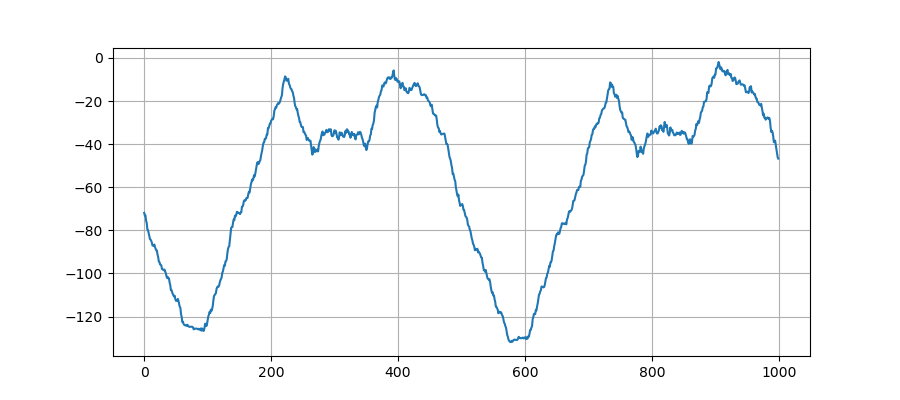

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [126]:
%matplotlib notebook

corr = np.zeros(1000, dtype = complex)
for i in range(1000):
    corr[i] = rx_iq_t[i:i+128].conj()@rx_iq_t[i+128:i+128+128]
    
    
plt.figure(figsize=(9, 4))
plt.plot(corr)
plt.grid(True)

In [3]:
d = 100
20*np.log10(4*np.pi*d*2e9/3e8)

78.46237209932829

In [40]:
nfft = 1024
ncp = 128
train_sym_len = 32
train_sym_repeat = 32
train_sym_full = train_sym_len*train_sym_repeat

pilot_carriers = np.arange(100, 400, 2)
pilot_values = 1.3 * np.exp(2j*np.pi*0.5*np.arange(pilot_carriers.size))




In [60]:
rx_iq = data[-1300]

<IPython.core.display.Javascript object>


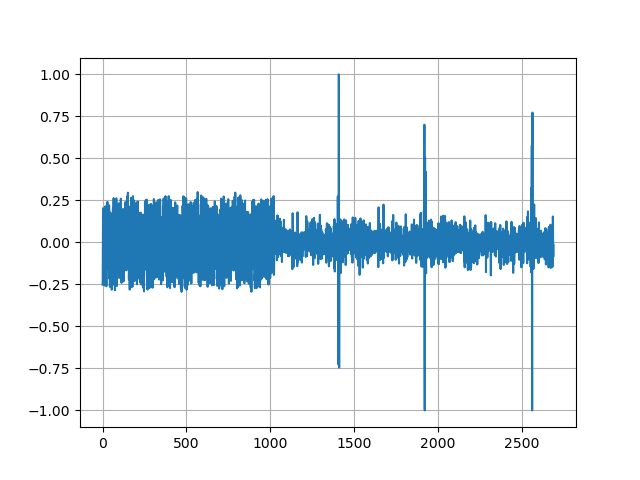

In [29]:
%matplotlib notebook

plt.plot(rx_iq.real)

plt.grid(True)

<IPython.core.display.Javascript object>


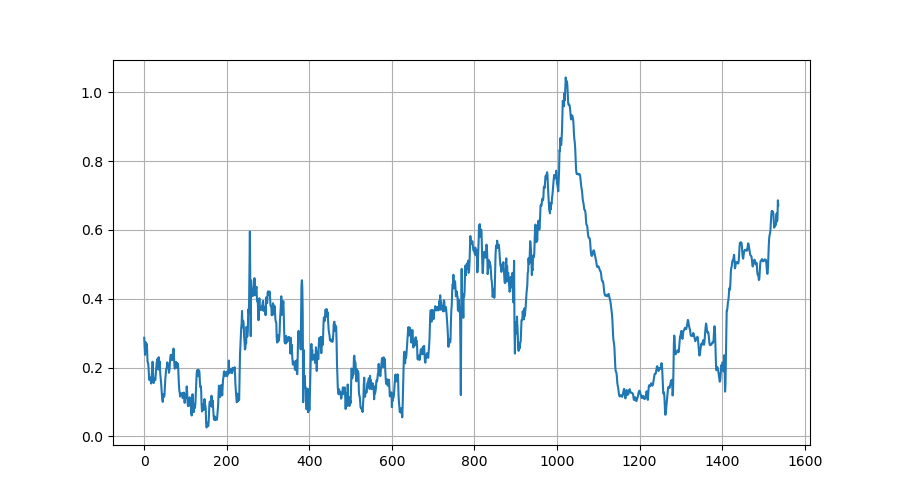

In [32]:
%matplotlib notebook

corr_128 = np.zeros(rx_iq.size-ncp-nfft+1, dtype=complex)
for i in range(corr_128.size):
    corr_128[i] = rx_iq[i:i + ncp].conj() @ \
                rx_iq[i + nfft: i+nfft+ncp]
    
plt.figure(figsize=(9, 5))

plt.plot(np.abs(corr_128))

plt.grid(True)

In [61]:


iq_t = rx_iq
train_sym_t = np.zeros((train_sym_repeat, train_sym_len), dtype=complex)
for i in range(train_sym_repeat):
    train_sym_t[i] = iq_t[i*train_sym_len:(i+1)*train_sym_len]

freq_offset = 0
for i in range(train_sym_repeat-1):
    corr = train_sym_t[i].conj() @ train_sym_t[i+1]
    print(np.angle(corr)/train_sym_len)
    freq_offset += np.angle(corr)/train_sym_len/(train_sym_repeat-1)

print(freq_offset)

ofdm_sym_t = iq_t[train_sym_len*train_sym_repeat + ncp//2: train_sym_len*train_sym_repeat + ncp//2 + nfft]
ofdm_sym_t = ofdm_sym_t * np.exp(1j*-freq_offset*np.arange(ofdm_sym_t.size))

-0.02298993876793489
-0.023663481679001983
-0.022971812377587573
-0.023445285728977347
-0.023641366120938537
-0.023276110708856743
-0.02288284682754491
-0.023785082642772244
-0.023323892296136968
-0.023438111926510376
-0.023208609568480587
-0.02322574843038195
-0.02332777566030733
-0.022853279574612126
-0.02397432416770176
-0.022863033513621744
-0.023234323071324926
-0.02374281697200262
-0.022990138173697362
-0.024328248132628388
-0.02276846176932441
-0.02317153243964609
-0.023426669311189512
-0.023862633758543677
-0.02309220020344064
-0.02298337566477721
-0.023662718574418526
-0.022912071378112357
-0.02322494680459542
-0.023665872611260887
-0.02327983523231692
-0.02332956593834342


In [62]:
ofdm_sym_f = np.fft.fft(ofdm_sym_t)
ofdm_sym_f *= np.exp(2j*np.pi*np.arange(nfft)*(ncp - ncp//2)/nfft)

In [63]:
ofdm_sym_f_tx = np.zeros(nfft, dtype=complex)
np.random.seed(123)
ofdm_sym_f_tx[100:400] = (np.random.choice([1, -1], 400-100) + 1j*np.random.choice([1, -1], 400-100))/np.sqrt(2)
#ofdm_sym_f_tx[-400:-100] = (np.random.choice([1, -1], 400-100) + 1j*np.random.choice([1, -1], 400-100))/np.sqrt(2)

ofdm_sym_f_tx[pilot_carriers] = pilot_values

<IPython.core.display.Javascript object>


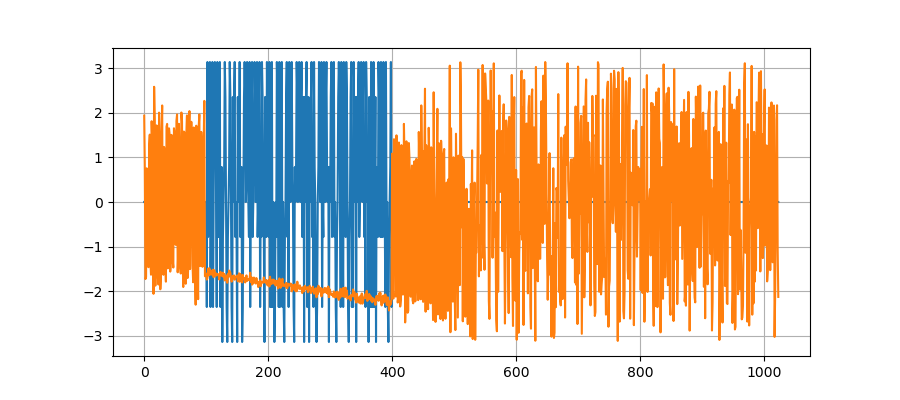

In [64]:
%matplotlib notebook

plt.figure(figsize=(9, 4))

plt.plot(np.angle(ofdm_sym_f_tx))
plt.plot(np.angle(ofdm_sym_f * np.exp(-1j*np.angle(ofdm_sym_f_tx))))

plt.grid(True)

In [43]:
train_sym_tx_t = zc_sequence(train_sym_len, 3, 0)
train_sym_tx_t_full = np.hstack([train_sym_tx_t]*train_sym_repeat)

ofdm_sym_f_tx = np.zeros(nfft, dtype=complex)

np.random.seed(123)
ofdm_sym_f_tx[100:400] = (np.random.choice([1, -1], 400-100) + 1j*np.random.choice([1, -1], 400-100))/np.sqrt(2)
ofdm_sym_f_tx[-400:-100] = (np.random.choice([1, -1], 400-100) + 1j*np.random.choice([1, -1], 400-100))/np.sqrt(2)

ofdm_sym_f_tx[pilot_carriers] = pilot_values
ofdm_sym_t_tx = np.fft.ifft(ofdm_sym_f_tx) * nfft / np.sqrt(1024)

frame = np.hstack([train_sym_tx_t_full] + [ofdm_sym_t[-ncp:], ofdm_sym_t])

In [17]:
17408/2176

8.0

In [18]:
9344/2176

4.294117647058823

In [14]:
corr_sz = 16
f_off_est = []
rxtx_corr = rx * tx.conj()
for i in range(rx.size//corr_sz-1):
    f_off_est.append(
        np.angle(rxtx_corr[corr_sz*(i+1): corr_sz*(i+2)] @ rxtx_corr[corr_sz*i: corr_sz*(i+1)].conj())/corr_sz
    )

print(np.array(f_off_est)/(2*np.pi))
    
    

[1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04
 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04
 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04
 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04
 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04
 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04
 1.e-04 1.e-04 1.e-04]


In [35]:
f = -0.4
N=10
iq_t = np.exp(2j*np.pi*f*np.arange(2*N))

cor = iq_t[::2] @ iq_t[1::2].conj()
f_est = -np.angle(cor)/1/(2*np.pi)
print(f_est)

-0.4


In [31]:
iq_t = iq_t*np.exp(2j*np.pi*-f_est*np.arange(2*N))
print(np.angle(iq_t))

[-0.000e+00 -6.283e-01 -1.257e+00 -1.885e+00 -2.513e+00 -3.142e+00
  2.513e+00  1.885e+00  1.257e+00  6.283e-01  3.331e-16 -6.283e-01
 -1.257e+00 -1.885e+00 -2.513e+00  3.142e+00  2.513e+00  1.885e+00
  1.257e+00  6.283e-01]


In [32]:
cor = iq_t[:N] @ iq_t[N:].conj()
f_est = -np.angle(cor)/N/(2*np.pi)
print(f_est)

3.7989958695258676e-18


[-0.000e+00 -6.283e-01 -1.257e+00 -1.885e+00 -2.513e+00 -3.142e+00
  2.513e+00  1.885e+00  1.257e+00  6.283e-01  3.331e-16 -6.283e-01
 -1.257e+00 -1.885e+00 -2.513e+00  3.142e+00  2.513e+00  1.885e+00
  1.257e+00  6.283e-01]


In [5]:
def zc_sequence(N, u, q):
    n = np.arange(N)
    arg = -np.pi*u*n*(n+(N%2)+2*q)/N
    return np.exp(1j*arg)

In [21]:
1024+128+64*4

1280

In [25]:
a = np.array([
    1, 1, 2, 2
])
a = a.reshape((2,2))

np.fft.fft(a, axis=1)

array([[2.+0.j, 0.+0.j],
       [4.+0.j, 0.+0.j]])

In [6]:
zc_s1 = zc_sequence(64, 3, 0)
zc_s2 = zc_sequence(64, 3, 2)


In [17]:
iq_tm = np.hstack((zc_s1, zc_s1))
eps = 10/1000
iq_tm = iq_tm * np.exp(1j*2*np.pi*eps*np.arange(iq_tm.size))

<IPython.core.display.Javascript object>


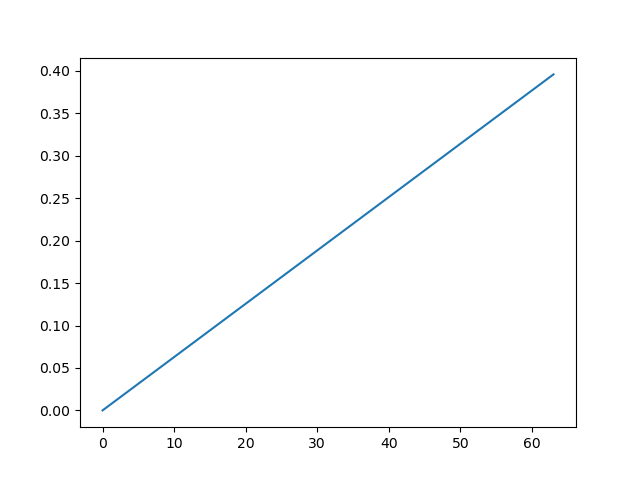

In [19]:
%matplotlib notebook

plt.plot(np.angle(iq_tm[:64]*zc_s1.conj()))

<IPython.core.display.Javascript object>


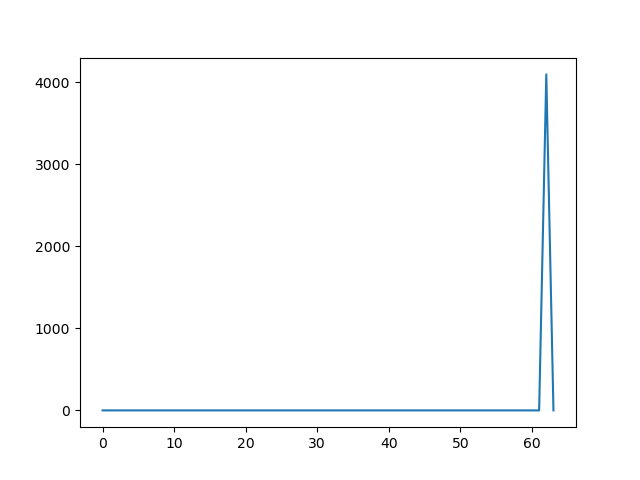

In [10]:
%matplotlib notebook
def periodic_corr(x, y):
    return np.fft.fft(np.fft.fft(x) * np.fft.fft(y).conj())

plt.plot(np.arange(64), np.abs(periodic_corr(zc_s1, zc_s2)))

In [3]:
np.roll([1, 2, 3, 4, 5], -2)

array([3, 4, 5, 1, 2])

In [4]:
nfft = 1024
nguard = 1024
f_idx = np.arange(nfft)

tx_f = np.random.choice([1, -1], nfft) + 1j*np.random.choice([1, -1], nfft)
tx_f[0] = 0

tx_t = np.fft.ifft(tx_f)
tx_tg = np.pad(tx_t, (0, nguard), mode='wrap')

In [27]:
rx_f = np.zeros_like(tx_f)

eps = 20*1e-6

for i in range(rx_f.size):
    rx_f[i] = np.sum(tx_t*np.exp(-2j*np.pi*f_idx*i*(1+eps)/nfft))

rx_t = np.fft.ifft(rx_f)
rx_tg = np.pad(rx_t, (0, nguard), mode='wrap')

In [30]:
rx_f1 = np.fft.fft(rx_t[:nguard])
rx_f2 = np.fft.fft(rx_t[-nguard:])

print(np.angle(rx_f2/tx_f))

[-2.356e+00 -2.535e-05 -6.405e-05 ... -6.408e-02 -7.361e-02 -3.283e-02]


/tmp/ipykernel_15060/1977258068.py:4: RuntimeWarning: divide by zero encountered in true_divide
  print(np.angle(rx_f2/tx_f))


In [8]:
tx_data = np.fromfile(open("rx_tx_records/tx_data"), dtype=np.complex64)
rx_data = np.fromfile(open("rx_tx_records/rx_data"), dtype=np.complex64)


In [ ]:
nfft = 1024
ng = 128

tx_t = tx_data[ng:ng+nfft]
tx_f = np.fft.fft(tx_t)

rx_skip = 1000
rx_f = rx_data[rx_skip*nfft:(rx_skip+1)*nfft]

<IPython.core.display.Javascript object>


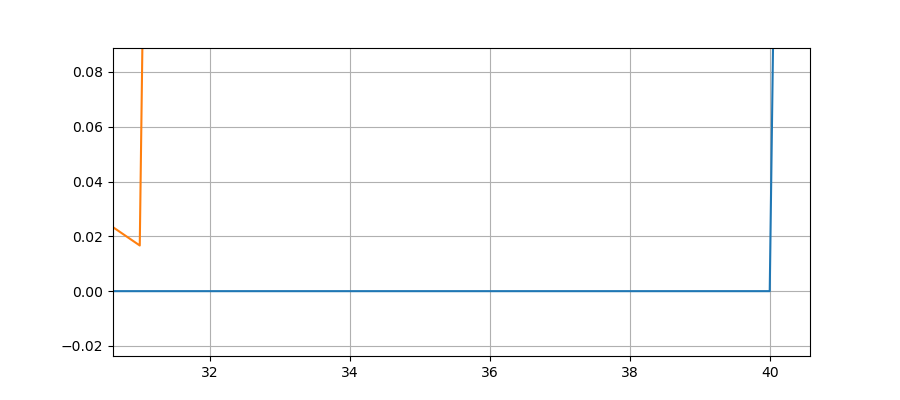

In [18]:
%matplotlib notebook


plt.figure(figsize=(9, 4))

plt.plot(np.abs(tx_f))
plt.plot(np.abs(rx_f)/10)

plt.grid(True)